In [1]:
import gym
import os
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import random
import numpy as np
from collections import deque
import torch
import contextlib
from torch import nn
from torch import optim
import torch.nn.functional as F
from plotly import graph_objects as go

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [3]:
ENV_ID = "BipedalWalker-v2"

GAMMA = 0.99
TAU = 0.05
BATCH_SIZE = 256
ACTOR_LR = 2e-4
CRITIC_LR = 1e-4
MAX_EPISODES = 1000
MAX_TIMESTAMPS = 500
SIGMA = 0.6
THETA = 0.15
EPS_MIN = 0.2
EPS_MAX = 1
CAPACITY = 50000
TEST_INTERVAL = MAX_EPISODES // 50 if MAX_EPISODES >= 50 else 1
TEST_EPISODES = 3
TD3_POLICY_DELAY = 2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class MemoryReplay:
    def __init__(self):
        self.memory = []
        self.index = 0
    
    def __len__(self):
        return len(self.memory)
    
    def append(self, elem):
        if len(self) < CAPACITY:
            self.memory.append(elem)
        else:
            self.memory[self.index] = elem
            self.index = (self.index + 1) % CAPACITY
            
    def sample(self):
        return [to_tensor(e) for e in zip(*random.sample(self.memory, BATCH_SIZE))]


def to_tensor(x, dtype=torch.float):
    return torch.tensor(x, dtype=dtype, device=DEVICE)

In [5]:
class Noiser:
    def __init__(self, action_space):
        self.theta = THETA
        self.sigma = SIGMA
        self.action_dim = action_space.shape[0]
        self.low = action_space.low[0]
        self.high = action_space.high[0]
        self.eps_max = EPS_MAX
        self.eps_min = EPS_MIN
        self.eps = self.eps_max
        self.eps_decay = (self.eps_max - self.eps_min) / MAX_EPISODES
        self.state = np.zeros(self.action_dim)

    def update_eps(self):
        self.eps -= self.eps_decay

    def apply(self, action, clip=False):
        self.state += - self.theta * self.state + self.sigma * np.random.randn(self.action_dim)
        noise = self.eps * self.state
        noise = np.clip(noise, -2 * SIGMA, 2 * SIGMA) if clip else noise
        if isinstance(action, torch.Tensor):
            return torch.clamp(action + to_tensor(noise), self.low, self.high)
        else:
            return np.clip(action + noise, self.low, self.high)

In [6]:
class Actor(nn.Module):
    def __init__(self, obs_size, act_size):
        super(Actor, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(obs_size, 400),
            nn.LayerNorm(400),
            nn.ReLU(),
            nn.Linear(400, 300),
            nn.LayerNorm(300),
            nn.ReLU(),
            nn.Linear(300, act_size),
            nn.Tanh(),
        )
    
    def forward(self, x):
        return self.net(x)
    
    def np_action(self, state):
        action = self.forward(torch.tensor(state, dtype=torch.float, device=DEVICE))
        return action.detach().cpu().numpy()


class Critic(nn.Module):
    def __init__(self, obs_size, act_size):
        super(Critic, self).__init__()

        self.obs_net = nn.Sequential(
            nn.Linear(obs_size, 400),
            nn.LayerNorm(400),
            nn.ReLU(),
        )

        self.out_net = nn.Sequential(
            nn.Linear(400 + act_size, 300),
            nn.LayerNorm(300),
            nn.ReLU(),
            nn.Linear(300, 1),
        )

    def forward(self, state, action):
        obs = self.obs_net(state)
        return self.out_net(torch.cat([obs, action], dim=1))

In [7]:
def td3_update(step):
    
    state, action, reward, next_state, done = replay_buffer.sample()
    critic1, critic2 = critic

    target_actions = noise.apply(actor.target(next_state), clip=True)
    expected_qvalue = torch.min(
        critic1.target(next_state, target_actions),
        critic2.target(next_state, target_actions),
    )
    expected_qvalue = reward.unsqueeze(1) + (1.0 - done.unsqueeze(1)) * GAMMA * expected_qvalue
    expected_qvalue = expected_qvalue.detach()
    qvalue1 = critic1(state, action)
    qvalue2 = critic2(state, action)

    loss1 = F.mse_loss(qvalue1, expected_qvalue)
    update_critic(critic1, loss1)
    
    loss2 = F.mse_loss(qvalue2, expected_qvalue)
    update_critic(critic2, loss2)

    if step % TD3_POLICY_DELAY == 0:
        actor_loss = - critic1(state, actor(state)).mean()
        actor.optimizer.zero_grad()
        actor_loss.backward()
        actor.optimizer.step()

        soft_update(critic1)
        soft_update(critic2)
        soft_update(actor)

def update_critic(critic, loss):
    critic.optimizer.zero_grad()
    loss.backward()
    critic.optimizer.step()
    
def soft_update(net):
    for target_param, param in zip(net.target.parameters(), net.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - TAU) + param.data * TAU)

In [8]:
def test_episode():
    state = env.reset() 
    done, episode_reward = False, 0
    while not done:
        action = actor.target.np_action(state)
        action = np.clip(action, env.action_space.low, env.action_space.high)
        state, reward, done, _ = env.step(action)
        episode_reward += reward
    return episode_reward


def test():
    return [test_episode() for _ in range(TEST_EPISODES)]

In [9]:
def play_episode():
    state = env.reset()
    noise.update_eps()
    ep_reward = 0

    for step in range(MAX_TIMESTAMPS):
        action = noise.apply(actor.np_action(state))
        next_state, reward, done, _ = env.step(action)

        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        ep_reward += reward

        if len(replay_buffer) > BATCH_SIZE:
            td3_update(step)
        
        if done:
            break
    
    return ep_reward

In [10]:
def get_context():
    env = gym.make(ENV_ID)    
    noise = Noiser(env.action_space)
    actor = define_actor(env)
    critic = define_critic(env)
    replay_buffer = MemoryReplay()
    
    return env, noise, actor, critic, replay_buffer

def get_critic(env):
    critic_local = Critic(env.observation_space.shape[0], env.action_space.shape[0]).to(DEVICE)
    critic_target = copy.deepcopy(critic_local)
    critic_optimizer = optim.Adam(critic_local.parameters(), lr=CRITIC_LR)
    critic = critic_local
    critic.target = critic_target
    critic.optimizer = critic_optimizer
    
    return critic
    
def define_critic(env):
    return (get_critic(env), get_critic(env))

def define_actor(env):
    actor_local = Actor(env.observation_space.shape[0], env.action_space.shape[0]).to(DEVICE)
    actor_target = copy.deepcopy(actor_local)
    actor_optimizer = optim.Adam(actor_local.parameters(), lr=ACTOR_LR)
    actor = actor_local
    actor.target = actor_target
    actor.optimizer = actor_optimizer
    
    return actor

In [11]:
def train_draft():
    train_rewards = []
    test_rewards = []

    for id_episode in tqdm(range(1, MAX_EPISODES + 1), total=MAX_EPISODES):

        # play + train episode
        reward = play_episode()

        # record episode reward
        train_rewards.append(reward)

        # evaluate by exploitation
        if id_episode % TEST_INTERVAL == 0:
            test_rewards.append(
                np.mean(test())
            )
            print(f"episode: {id_episode} | exploit reward: {test_rewards[-1]:.3f}")

    return train_rewards, test_rewards

In [13]:
env, noise, actor, critic, replay_buffer = get_context()
train_rewards, test_rewards = train_draft()

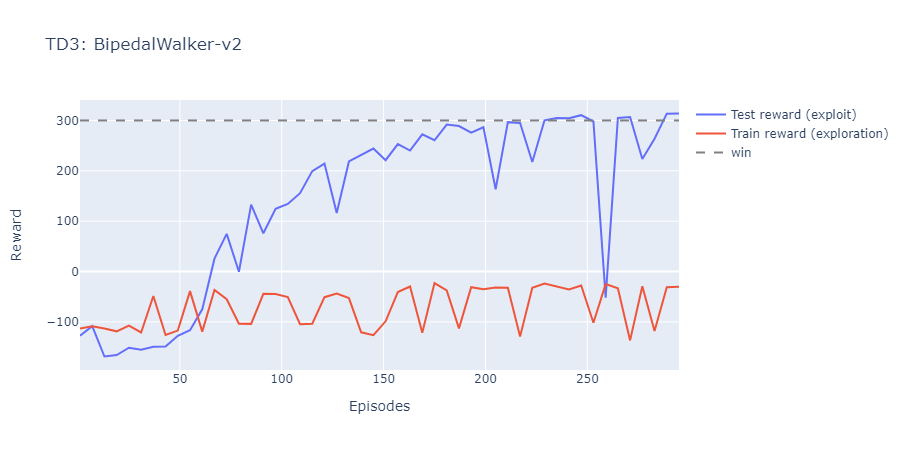

In [17]:
def draw():
    step = MAX_EPISODES // len(test_rewards)
    x = list(range(1, MAX_EPISODES + 2, step))[:len(test_rewards)]
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=test_rewards, name="Test reward (exploit)"))
    fig.add_trace(go.Scatter(x=x, y=train_rewards, name="Train reward (exploration)"))
    fig.add_trace(go.Scatter(x=x, y = [300] * len(test_rewards), line=dict(color="grey", width=2, dash="dash"), name="win"))
    fig.update_layout(
            xaxis = dict(title_text="Episodes"),
            yaxis = dict(title_text="Reward"), 
            title_text = "TD3: {}".format(ENV_ID)
        )
    fig.show()
    
draw()